In [18]:
# Initial notebook by Xishui
# Unit Data analysis on site Sept 2024
# (no recons data here)
    
import numpy as np
import matplotlib.pyplot as plt
# import glob
from scipy.fft import rfftfreq, rfft, irfft
from grand import ECEF, Geodetic, GRANDCS, LTP
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
import os 
import datetime
import grand.dataio.root_trees as rt
plt.style.use("/home/olivier/GRAND/soft/l3.mplstyle")

#data_dir = "/home/olivier/GRAND/data/GP300/GP13/onsite/sept2024/"
data_dir = "/home/olivier/GRAND/data/GP300/gp80/"

In [39]:
#flist = [data_dir + "GP13_20240911_033905_RUN127_UD_RAW_10hz_ChanXYZ_20dB_DU41_Beacontest_002_dat.root"]  # 1st run with 2 DUs
#flist = [data_dir + "GP13_20240912_095650_RUN127_UD_RAW_ChanXYZ_20dB_12dus_BeaconTest_BeaconON_FIRMWARE_V1B_1.1.1_001_dat.root"]  # 
#flist = [data_dir + "GP13_20240913_025557_RUN127_UD_RAW_ChanXYZ_20dB_DU23_10Hz_Beacontest_001_dat.root"]  # Beacon on DU23 only
#flist = [data_dir + "GP13_20240913_040359_RUN127_UD_RAW_ChanXYZ_20dB_DU23_10Hz_Beacontest_001_dat.root"]  # Beacon on DU23 only + notch filter
#flist = [data_dir + "GP13_20240913_041642_RUN127_UD_RAW_ChanXYZ_20dB_DU23_10Hz_Beacontest_001_dat.root"]  # Beacon on DU23 only + notch filter + 1kHz rep
#flist = [data_dir + "GP13_20240913_045413_RUN127_UD_RAW_ChanXYZ_20dB_12DUs_10Hz_Beacontest_Notchfilter_132_001_dat.root"]  # Idem previous except 100ms and all DUs
#flist = [data_dir + "GP13_20240913_065809_RUN133_MD_RAW_ChanXYZ_20dB_12DUs_20Hz_Beacontest_Notchfilter_132_001_dat.root"]  # Beacon 2mus + MD + all DUs
#flist = [data_dir + "GP13_20240913_105214_RUN127_UD_RAW_ChanXYZ_20dB_11DUs_OFF_BeaconTest_001_dat.root"]  # Beacon OFF all DUs and optimized trigger
#flist = [data_dir + "GP13_20240913_105055_RUN127_UD_RAW_ChanXYZ_20dB_11DUs_ON_BeaconTest_001_dat.root"]  # Beacon 100ms all DUs and optimized trigger
#flist = [data_dir + "GP13_20240913_124600_RUN133_MD_RAW_20Hz_ChanXYZ_20dB_13DUs_002_dat.root"]  # 20Hz everybody
#flist = [data_dir + "GP13_20240914_024926_RUN0914_MD_RAW_ChanXYZ_20dB_10Hz_75MHz_BeaconTest_001_dat.root"]  # Beacon 100ms + 2 notch filters
#flist = [data_dir + "GP13_20240914_040311_RUN0914_UD_RAW_ChanXYZ_20dB_10Hz_75MHz_BeaconTest_001_dat.root"]  # Beacon 100ms + 1 notch filter
#flist=[data_dir+"GP13_20241030_100131_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_GP13_XorY_Y2FLOAT_X2Z_DunhuangTEST_001_dat.root"] # Test in October with beacon @ ground
#flist=[data_dir+"GP13_20241031_045953_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_GP13_XorY_Y2FLOAT_X2Z_DunhuangTEST_001_dat.root"] # Beacon test again: 115MHz + 5 cycles 
#flist=[data_dir+"GP13_20241031_052605_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_GP13_XorY_Y2FLOAT_X2Z_DunhuangTEST_003_dat.root"] # 75MHz + 3cycles + new cable
flist=[data_dir+"GP13_20241031_054012_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_GP13_XorY_Y2FLOAT_X2Z_DunhuangTEST_002_dat.root"] # 115MHz + 5 cycles
flist=[data_dir+"GP13_20241031_054012_RUN127_UD_RAW_ChanXYZ_20dB_10DUs_GP13_XorY_Y2FLOAT_X2Z_DunhuangTEST_002_dat.root"] # 115MHz + 5 cycles

list_trigger_time = [] # Time of trigger in seconds
list_trigger_nano = [] # Time of trigger in seconds
list_traces_MD = []
list_traces = []
list_time_MD = []
list_du_id_MD = []
list_du_id = []
list_du_long = []
list_du_lat = []
list_du_alt = []

for fname in flist:
        
    root_file = rt.DataFile(fname)
    n = root_file.tadc.get_number_of_entries()
    for i in range(n):
      if i/100 == int(i/100):
        print(i,n)
      root_file.tadc.get_entry(i)
      root_file.trawvoltage.get_entry(i)
    
      if ~np.all(root_file.tadc.trigger_pattern_10s) and np.any(root_file.tadc.trigger_pattern_ch):
        # UD data
        #print("0:",root_file.tadc.du_seconds[0])
        if root_file.tadc.du_seconds[0]>2045518457:  # Skip wrong GPS time
            #print("coco")
            continue
        #print("1:",root_file.tadc.du_seconds[0])
        #print(root_file.trawvoltage.gps_long)
        list_trigger_time.append(root_file.tadc.du_seconds[0])
        list_trigger_nano.append(root_file.tadc.du_nanoseconds[0])
        list_du_id.append(root_file.tadc.du_id[0])
        list_du_long.append(root_file.trawvoltage.gps_long[0])
        list_du_lat.append(root_file.trawvoltage.gps_lat[0])
        list_du_alt.append(root_file.trawvoltage.gps_alt[0])
        
        _traces = []
        _traces.append(root_file.tadc.trace_ch[0][0])
        _traces.append(root_file.tadc.trace_ch[0][1])
        _traces.append(root_file.tadc.trace_ch[0][2])
        _traces.append(root_file.tadc.trace_ch[0][3])
        list_traces.append(_traces)
# list_trigger_time should already be sorted in the root file
# Convert list to np.array
list_trigger_time = np.array(list_trigger_time)  # seconds
list_trigger_nano = np.array(list_trigger_nano)  # nanseconds
list_du_id = np.array(list_du_id)
list_time_MD = np.array(list_time_MD)
list_du_id_MD = np.array(list_du_id_MD)
list_traces_MD = np.array(list_traces_MD)
list_traces = np.array(list_traces)
list_du_long = np.array(list_du_long)
list_du_lat = np.array(list_du_lat)
list_du_alt = np.array(list_du_alt)

du_list,idu = np.unique(list_du_id,return_index=True)
du_MD_list = np.unique(list_du_id_MD)
du_long = np.unique(list_du_long)
du_lat = np.unique(list_du_lat)
du_alt = np.unique(list_du_alt)
print(list_du_id[idu])
print(list_du_long[idu])
print(list_du_lat[idu])
print(list_du_alt[idu])

0 4014
100 4014
200 4014
300 4014
400 4014
500 4014
600 4014
700 4014
800 4014
900 4014
1000 4014
1100 4014
1200 4014
1300 4014
1400 4014
1500 4014
1600 4014
1700 4014
1800 4014
1900 4014
2000 4014
2100 4014
2200 4014
2300 4014
2400 4014
2500 4014
2600 4014
2700 4014
2800 4014
2900 4014
3000 4014
3100 4014
3200 4014
3300 4014
3400 4014
3500 4014
3600 4014
3700 4014
3800 4014
3900 4014
4000 4014
[1018 1023 1038 1040 1043 1045 1048 1058 1059 1065]
[93.95416925 93.95409424 93.94903341 93.96481165 93.95916533 93.96402053
 93.96950905 93.96918314 93.95381051 93.95914872]
[40.98451614 40.99369973 40.99135205 40.97992482 40.98757751 40.98437015
 40.99119118 40.9861296  40.97984428 40.97810358]
[1221.3554  1187.38785 1203.83065 1218.70165 1214.79775 1214.53975
 1201.1389  1201.7119  1226.89335 1231.54185]


Text(0, 0.5, 'Northing (m)')

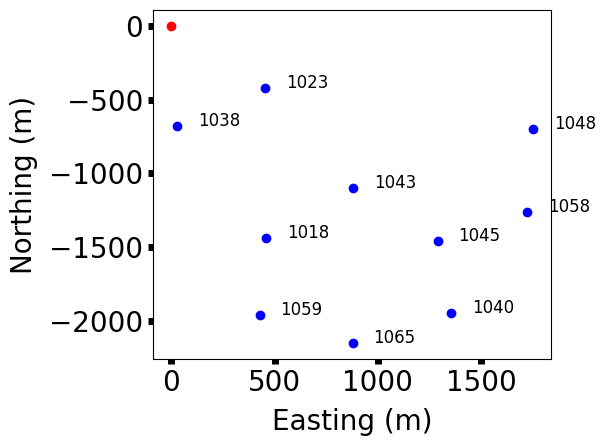

In [40]:
from grand import ECEF, Geodetic, GRANDCS, LTP
from grand import Geomagnet
from grand import Topography, Reference, geoid_undulation
from grand import topography

daq   = Geodetic(latitude=40.99746387, longitude=93.94868871, height=1215)   # lat, lon of the center station (from FEB@rocket)
dus_feb = Geodetic(latitude=list_du_lat[idu], longitude=list_du_long[idu], height=list_du_alt[idu])
dus_feb = GRANDCS(dus_feb, obstime="2024-09-15", location=daq)
plt.plot(-dus_feb.y,dus_feb.x,'ob')
plt.plot(0,0,'or')
for i in range(len(idu)):
    plt.text(-dus_feb.y[i]+100,dus_feb.x[i],list_du_id[idu][i],fontsize=12)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")


In [41]:
r_exp = 100 # Hz

list_true_time = list_trigger_time*1e9+list_trigger_nano # in ns
dur = (np.max(list_true_time)-np.min(list_true_time))/1e9

print("UD data on DUs:",du_list)
print("UD data duration (s) =",dur)

#plt.figure()
for target_du in du_list:
    dumask = list_du_id == target_du
    t_du = (list_true_time[dumask]-np.min(list_true_time))/1e9
    dur_du = t_du[-1]-t_du[0]
    print(target_du,":",np.sum(dumask),'events in',dur_du,"s")
    r_true = np.sum(dumask)/dur
    print("Rate (Hz) =",r_true, r_true/r_exp)
    #plt.plot(list_trigger_time[dumask],label=str(du))
#plt.legend(loc='best')

UD data on DUs: [1018 1023 1038 1040 1043 1045 1048 1058 1059 1065]
UD data duration (s) = 5.410002432
1018 : 427 events in 5.150001408 s
Rate (Hz) = 78.92787579434493 0.7892787579434493
1023 : 335 events in 5.130001664 s
Rate (Hz) = 61.92233815247202 0.6192233815247202
1038 : 7 events in 3.2300011520000003 s
Rate (Hz) = 1.2938996031859824 0.012938996031859823
1040 : 512 events in 5.190001408 s
Rate (Hz) = 94.63951383303187 0.9463951383303187
1043 : 515 events in 5.180001792 s
Rate (Hz) = 95.19404223439729 0.9519404223439729
1045 : 355 events in 5.110001408 s
Rate (Hz) = 65.61919416157482 0.6561919416157482
1048 : 487 events in 5.150001408 s
Rate (Hz) = 90.01844382165335 0.9001844382165335
1058 : 515 events in 5.400001792 s
Rate (Hz) = 95.19404223439729 0.9519404223439729
1059 : 392 events in 5.140001536 s
Rate (Hz) = 72.45837777841503 0.7245837777841503
1065 : 469 events in 5.240001536 s
Rate (Hz) = 86.69127341346083 0.8669127341346083


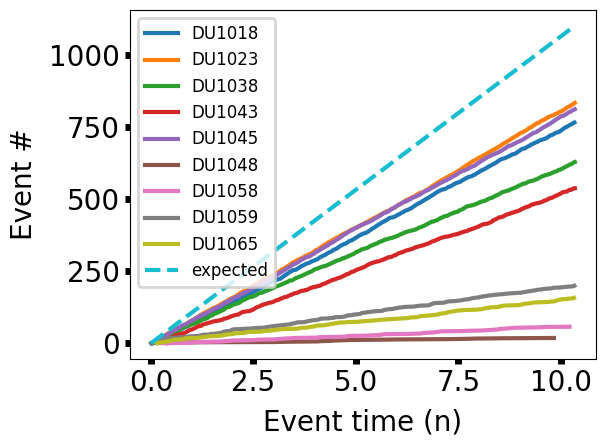

In [23]:
for target_du in du_list:
    dumask = list_du_id == target_du
    t_du = (list_true_time[dumask]-np.min(list_true_time))/1e9
    #plt.semilogy(t_du,np.arange(sum(dumask)),label='DU'+str(target_du))
    plt.plot(t_du,np.arange(np.sum(dumask)),label='DU'+str(target_du))
plt.xlabel('Event time (n)')
plt.ylabel('Event #')
a = np.arange(0.1,(np.max(list_true_time)-np.min(list_true_time))/1e9)
plt.plot([0,(np.max(list_true_time)-np.min(list_true_time))/1e9],[0,r_exp*(np.max(list_trigger_time)-np.min(list_trigger_time))],'--',label='expected')
#plt.semilogy(a,10*a,'--',label='expected')
plt.legend(loc='best')    
#plt.ylim([0,200])    

## Plot events

Text(0, 0.5, 'abs(FFT)')

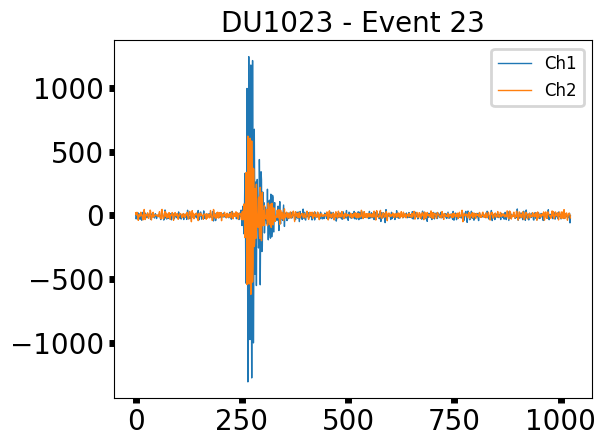

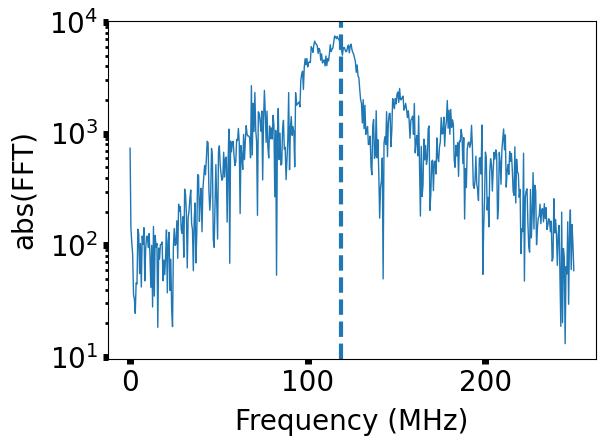

In [42]:
target_du = 1023
evtid = 23

dumask = list_du_id == target_du
 
plt.figure()
for ich in range(1,3):
  lab = "Ch"+str(ich)
  plt.plot(list_traces[dumask,ich,:][evtid],label=lab,linewidth=1)
  #plt.xlim(200,400)
plt.legend(loc='best')
tit = "DU"+str(target_du)+" - Event "+str(evtid)
plt.title(tit)

plt.figure()
afft = abs(rfft(list_traces[dumask,ich,:][evtid]))
freq = rfftfreq(len(list_traces[dumask,ich,:][evtid]),2e-3)  # in MHz with 2ns seperation given in mus
plt.axvline(118.9,ls='--')

plt.semilogy(freq,afft,linewidth = 1)
plt.xlabel("Frequency (MHz)")
plt.ylabel("abs(FFT)")


## Plot mean FFT

In [8]:
target_du = 1045
dumask = list_du_id == target_du
nevts = np.sum(list_du_id == target_du)
# 
npts = len(list_traces[dumask,0,:][0])
mafft = np.zeros((4,int(npts/2)+1))
#for ev in range(nevts):
#    if int(ev/100) == ev/100:
#        print(ev,nevts)
    #for ich in range(4):
#    afft = abs(rfft(list_traces[dumask,ich,:][ev]))
#    mafft[ich] += afft
#mafft /= nevts
freq = rfftfreq(npts,2e-3)  # in MHz with 2ns seperation given in mus
mfft = np.mean(abs(rfft(list_traces[dumask],axis=2)),axis=0)


In [ ]:
plt.figure()
tit = "Mean FFT - DU"+str(target_du)
plt.title(tit)
lab = ['FiltX','X','Y','FiltY']
for ich in range(0,4):
    #lab = "Ch"+str(ich)
    plt.semilogy(freq,mfft[ich,:],lw = 1, label=lab[ich])
plt.xlabel("Frequency (MHz)")
plt.ylabel("abs(FFT)")
plt.legend(loc='best')
plt.xlim(100,150)
plt.axvline(118.9,ls='--')
plt.axvline(120.6,ls='--')
plt.axvline(137.75,ls='--')


## Plot amplitude hists

In [ ]:
good_du_list = [1018,1023,1038,1041,1043,1045]
#good_du_list = [1023]

tit = ['FiltX', 'ChX', 'ChY', 'FiltY','quad(ChX+ChY)']  # During beacon tests 
for target_du in good_du_list:
    print(target_du)
    dumask = list_du_id == target_du
    for ich in range(4):
        #print(np.shape(list_traces[dumask,ich,:]))
        #print(np.max(list_traces[dumask,ich,:],axis=1))
        plt.figure(ich+1)
        plt.hist(np.max(list_traces[dumask,ich,:],axis=1),bins=np.arange(0,400,4),label='DU'+str(target_du),histtype='step',lw=3)
        plt.legend(loc='best')
        plt.title(tit[ich])
    plt.figure(5)
    maxXY = np.sqrt(np.max(list_traces[dumask,1,:],axis=1)**2+np.max(list_traces[dumask,2,:],axis=1)**2)    
    plt.hist(maxXY,bins=np.arange(0,400,4),label='DU'+str(target_du),histtype='step',lw=3)
    plt.legend(loc='best')
    plt.title('quad(X, Y)')
    

## Plot time distrib

[]

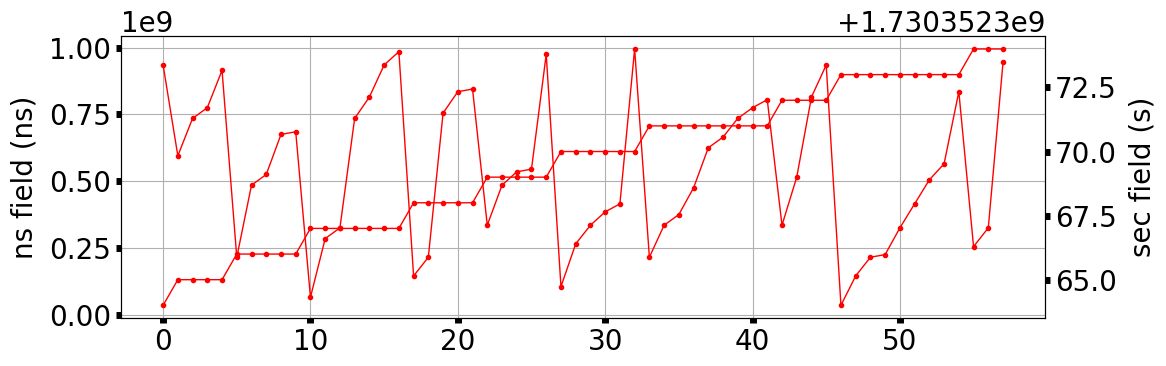

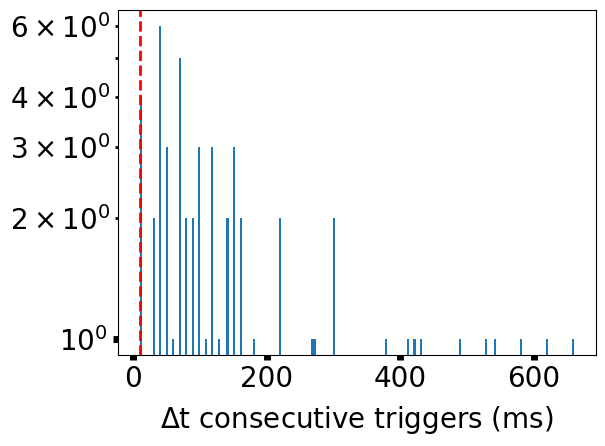

In [37]:
target_du = 1058
dumask = list_du_id == target_du

plt.figure(figsize=(12, 4))
plt.plot(list_trigger_nano[dumask], marker='.', color='r', markersize=6, lw=1)
#plt.plot(list_trigger_nano[du1043], marker='.', color='b', markersize=6, lw=1)
plt.grid()
plt.ylabel('ns field (ns)')
plt.twinx()
plt.plot(list_trigger_time[dumask], marker='.', color='r', markersize=6, lw=1);
#plt.plot(list_trigger_time[du1043], marker='.', color='b', markersize=6, lw=1);
#plt.xlim(0,200)
plt.xlabel('Event ID')
plt.ylabel('sec field (s)')

plt.figure()
dt = np.diff(list_true_time[dumask])*1e-6
plt.hist(dt[dt>0],200)
plt.xlabel('$\Delta$t consecutive triggers (ms)')
plt.axvline(1e3/r_exp,ls='--',color='r',lw=2)
plt.semilogy()